In [1]:
import json
import os
import glob
import pandas as pd

In [2]:
os.chdir("asset")
extension = 'json'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [3]:
tweets = []
for file in all_filenames:
    for line in open( file, 'r'):
        tweets.append(json.loads(line))

In [4]:
#clean duplicate
id_list=[]
new_tweets=[]
text_list=[]
for tweet in tweets:
    if tweet['id'] not in id_list:
        new_tweets.append(tweet)
        id_list.append(tweet['id'])
        text_list.append(tweet['text'])

In [124]:
new_tweets[0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Mar 16 01:09:46 +0000 2020',
 'entities': {'hashtags': [{'indices': [1, 13], 'text': 'THISIsATime'},
   {'indices': [17, 22], 'text': 'PLAN'},
   {'indices': [31, 37], 'text': 'Panic'},
   {'indices': [72, 85], 'text': 'TeleTownHall'},
   {'indices': [86, 109], 'text': 'ProtectingOurCommunity'}],
  'symbols': [],
  'urls': [{'display_url': 'twitter.com/i/web/status/1…',
    'expanded_url': 'https://twitter.com/i/web/status/1239358160105857024',
    'indices': [111, 134],
    'url': 'https://t.co/mIVPRfflwq'}],
  'user_mentions': [{'id': 2906442505,
    'id_str': '2906442505',
    'indices': [39, 51],
    'name': 'Traci Blackmon',
    'screen_name': 'pastortraci'},
   {'id': 44988185,
    'id_str': '44988185',
    'indices': [55, 61],
    'name': 'NAACP',
    'screen_name': 'NAACP'}]},
 'favorite_count': 1,
 'favorited': False,
 'geo': None,
 'id': 1239358160105857024,
 'id_str': '1239358160105857024',
 'in_reply_to_screen

In [6]:
# time convertion to LA timezone
from datetime import datetime
from email.utils import parsedate_tz, mktime_tz

def to_local_time(tweet_time_string):
   
    timestamp = mktime_tz(parsedate_tz(tweet_time_string))
    return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

In [7]:
df = pd.DataFrame([{"tweet_id": x['id'],
                         "date": to_local_time(x['created_at']),
                         "text": x['text'],                    
                         "favorite_count":x['favorite_count'],
                         'retweet_count':x['retweet_count'],
                         "at_mentions": [u["name"] for u in x['entities']['user_mentions']],
                         "at_mentions_id": [u["id"] for u in x['entities']['user_mentions']],
                         "hashtags": [v['text'] for v in x['entities']['hashtags']],
                         "user_id": x['user']['id'],
                         'user_name':x['user']['name'],
                         'user_profile':x['user']['description'],
                         'in_reply_to_tweet_id':x['in_reply_to_status_id'],
                         'country':x['place']['country'],
                          'place':x['place']['name'],
                          'lang':x['lang'],
                         'coordinates':x['place']['bounding_box']['coordinates'][0][0]} for x in new_tweets]).set_index("tweet_id")

In [8]:
df_US_origin=df[df['country'] == 'United States']

In [9]:
df_US_origin=df[df['lang'] == 'en']

In [10]:
df_US_origin[['latitude','longitude']]=pd.DataFrame(df_US_origin.coordinates.values.tolist(), 
                                                    index=df_US_origin.index, columns=['latitude','longitude'])

C:\Users\Think\A3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [11]:
df_US_origin['at_mentions']

tweet_id
1239358160105857024                           [Traci Blackmon, NAACP]
1239358141869035526                                                []
1239358032716365825                                                []
1239358007282106368                                                []
1239357938998939650                                                []
                                            ...                      
1240616013814738945                 [Klaus Iohannis, President Trump]
1240615999751192577    [Lori Lightfoot, JB Pritzker, President Trump]
1240615983808733186                         [LifeLine Animal Project]
1240615967786446849                                                []
1240615950577283073             [Garrett Haake, Governor Mike DeWine]
Name: at_mentions, Length: 5919, dtype: object

In [20]:
os.chdir("record")

df_US_origin.to_csv("origin_data.csv")

In [13]:
#Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):

    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[@%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [14]:
def clean_text_round2(text):
    text = re.sub('[‘’“”…]', ' ', text)
    text = re.sub('\n', ' ', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [15]:
df_US_origin['tidy_text'] = df_US_origin.text.apply(round1).apply(round2)
df_US=df_US_origin

C:\Users\Think\A3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Word Frequency

In [16]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer

def tweet_tokenizer(verbatim):
    try:
        tokenizer = TweetTokenizer()
        all_tokens = tokenizer.tokenize(verbatim.lower())
        filtered_tokens = [t for t in all_tokens if t.islower()]
        filtered_tokens = [x for x in filtered_tokens if len(x)>2]
    except IndexError:
        filtered_tokens = []
    return(filtered_tokens)

In [17]:
# get the most common words in Tweets
from sklearn.feature_extraction.text import CountVectorizer

def get_frequent_terms(text_series, stop_words = None, ngram_range = (1,2)):
    
    count_vectorizer = CountVectorizer(analyzer = "word",
                                       tokenizer = tweet_tokenizer,
                                       stop_words = stop_words, 
                                       ngram_range = ngram_range)
    term_freq_matrix = count_vectorizer.fit_transform(text_series)
    terms = count_vectorizer.get_feature_names()
    term_frequencies = term_freq_matrix.sum(axis = 0).tolist()[0]

    term_freq_df = (pd.DataFrame(list(zip(terms, term_frequencies)), columns = ["token","count"])
                    .set_index("token")
                    .sort_values("count",ascending = False))
    return term_freq_df

In [18]:
term_freq_df = get_frequent_terms(df_US["tidy_text"], stop_words = "english")
term_freq_df.to_csv("term_freq.csv")

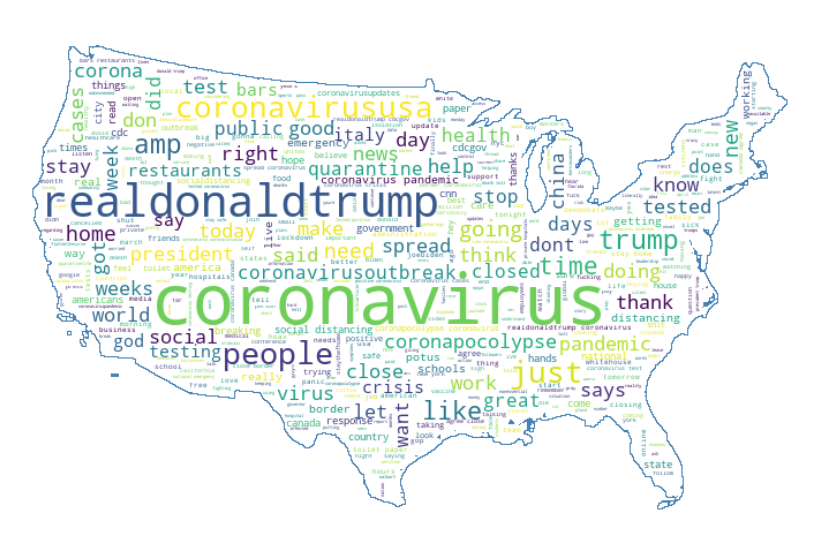

In [22]:
# all the words
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

stopwords = set(STOPWORDS)
pattern = np.array(Image.open("../pic/USA_map.png"))
wordcloud=WordCloud(background_color="white", max_words=2000, mask=pattern,
               stopwords=stopwords, contour_width=1, contour_color='steelblue', width=1024, height=720).generate_from_frequencies(frequencies=term_freq_df['count'])
plt.figure(figsize=(50,10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()
wordcloud.to_file("../wordcloud/term_freqs.png")

In [23]:
## remove words used when searching data
term_freq_cl=term_freq_df[~term_freq_df.index.isin(['coronavirususa','coronavirus','realdonaldtrump'])]

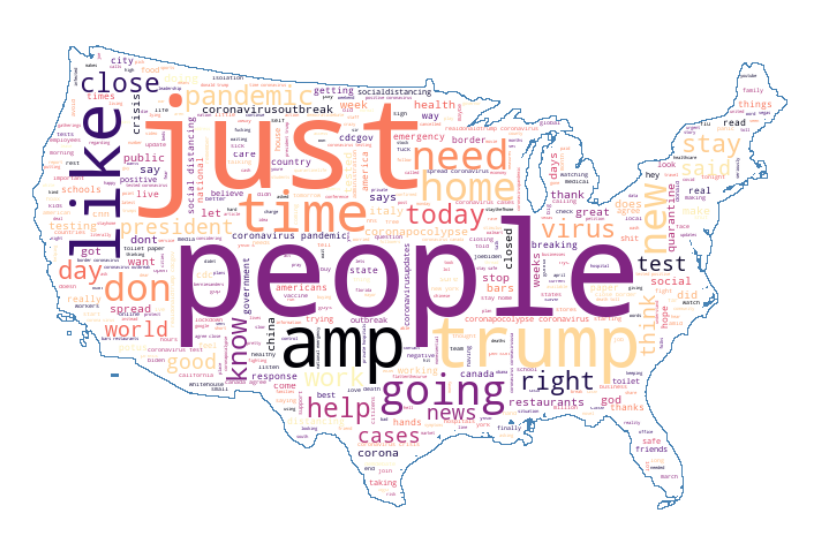

In [24]:
pattern = np.array(Image.open("../pic/USA_map.png"))
wordcloud=WordCloud(background_color="white", max_words=2000, mask=pattern,colormap='magma',
               stopwords=stopwords, contour_width=1, contour_color='steelblue', width=1024, height=720).generate_from_frequencies(frequencies=term_freq_cl['count'])
plt.figure(figsize=(50,10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()
wordcloud.to_file("../wordcloud/term_freqs_cl.png")

### what most people care about among 'heat' tweets?

In [25]:
df_US['heat']=df_US['favorite_count']+df_US['retweet_count']

C:\Users\Think\A3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
df_hottopic=df_US.sort_values(by=['heat'],ascending=False)
df_hottopic_filter=df_hottopic[df_hottopic['heat']>=df_hottopic['heat'].mean()]

In [27]:
df_hottopic_freq=get_frequent_terms(df_hottopic_filter["tidy_text"], stop_words = "english")

In [28]:
df_hottopic_freq.to_csv("hottopic_freq.csv")

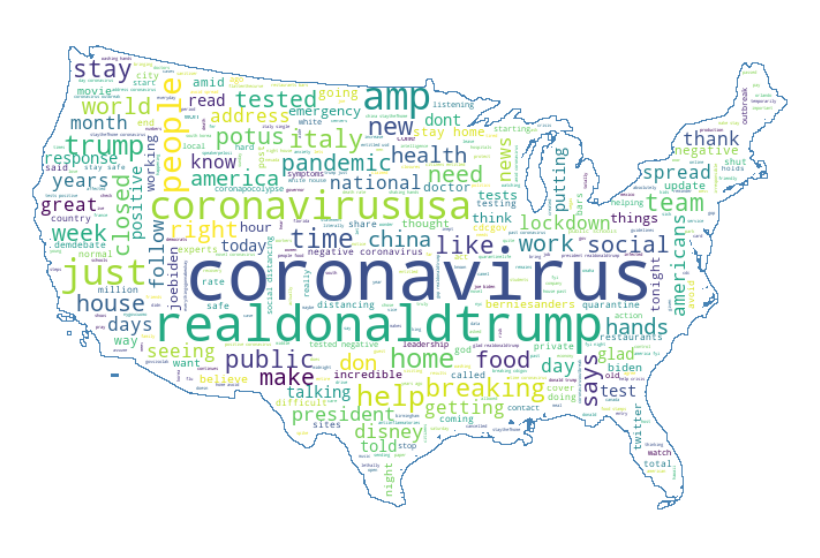

In [29]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

stopwords = set(STOPWORDS)
stopwords.add("token")
pattern = np.array(Image.open("../pic/USA_map.png"))
wordcloud=WordCloud(background_color="white", max_words=2000, mask=pattern,
               stopwords=stopwords, contour_width=1, contour_color='steelblue', width=1024, 
                    height=720).generate_from_frequencies(frequencies=df_hottopic_freq['count'])
plt.figure(figsize=(50,10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()
wordcloud.to_file("../wordcloud/hottopics_freqs.png")

In [30]:
## remove words used when searching data
df_hottopic_cl=df_hottopic_freq[~df_hottopic_freq.index.isin(['coronavirususa','coronavirus','realdonaldtrump'])]

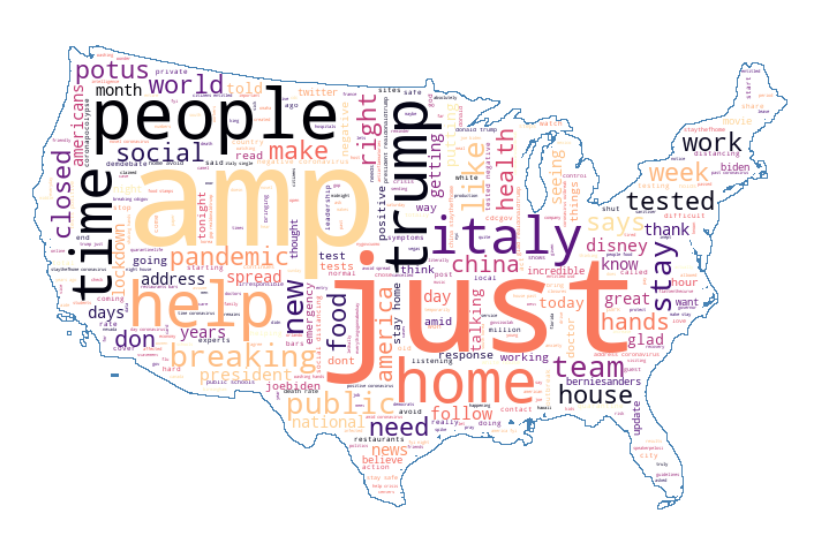

In [31]:
pattern = np.array(Image.open("../pic/USA_map.png"))
wordcloud=WordCloud(background_color="white", max_words=2000, mask=pattern,colormap='magma',
               stopwords=stopwords, contour_width=1, contour_color='steelblue', 
                    width=1024, height=720).generate_from_frequencies(frequencies=df_hottopic_cl['count'])
plt.figure(figsize=(50,10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()
wordcloud.to_file("../wordcloud/hottopics_freqs_cl.png")

### Who was mentioned most?

In [32]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None and len(lst_cols) > 0 and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    
    idx_cols = df.columns.difference(lst_cols)
    lens = df[lst_cols[0]].str.len()
    idx = np.repeat(df.index.values, lens)
    res = (pd.DataFrame({col:np.repeat(df[col].values, lens) for col in idx_cols},index=idx).assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    if (lens == 0).any():
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    res = res.sort_index()
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [33]:
df_atmentions=explode(df_US, ['at_mentions','at_mentions_id'], fill_value='')

In [34]:
df_mentions=df_atmentions.groupby(['at_mentions']).count().filter(['user_id']).sort_values(by=['user_id'], ascending =False)[1:]

In [92]:
mentions_list=df_mentions[df_mentions['user_id']>15]
mentions_list

,user_id
at_mentions,
Donald J. Trump,1023
President Trump,62
CDC,58
Vice President Mike Pence,53
Joe Biden (Text Join to 30330),37
GOP,36
The White House,35
CNN,29
Bernie Sanders,28


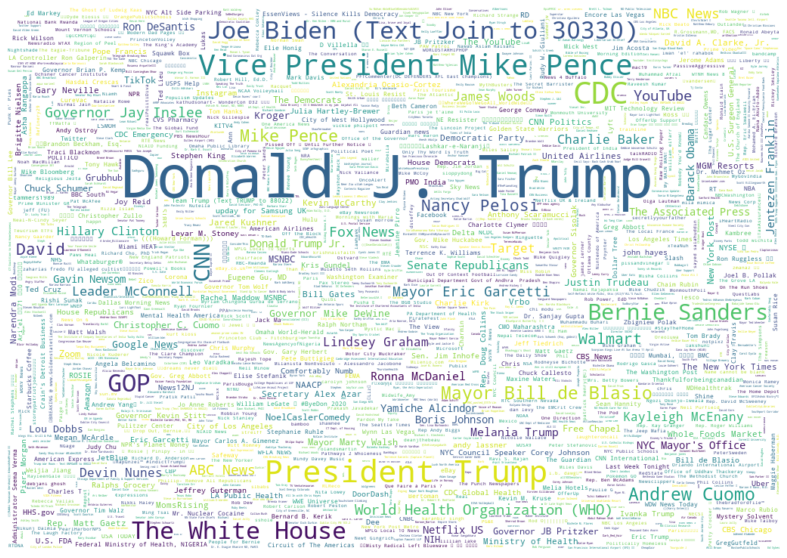

In [36]:
wordcloud=WordCloud(background_color="white", max_words=2000,stopwords=stopwords,
                    width=1024, height=720).generate_from_frequencies(frequencies=df_mentions['user_id'])
plt.figure(figsize=(50,10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()
wordcloud.to_file("../wordcloud/at_mentions.png")

## After lSTM model Prediciton

In [57]:
df=pd.read_csv('../record/all_data.csv',index_col='tweet_id')

In [64]:
df_US['tone']=list(df['tone'])

In [100]:
df_US

,date,text,favorite_count,retweet_count,at_mentions,at_mentions_id,hashtags,user_id,user_name,user_profile,in_reply_to_tweet_id,country,place,lang,coordinates,latitude,longitude,tidy_text,heat,tone
tweet_id,,,,,,,,,,,,,,,,,,,,
1239358160105857024,2020-03-15 18:09:46,“#THISIsATime to #PLAN and NOT #Panic” @pastor...,1,0,"[Traci Blackmon, NAACP]","[2906442505, 44988185]","[THISIsATime, PLAN, Panic, TeleTownHall, Prote...",728301752,Shameem Clark Hubbard,"Alderwoman 26ThWard,City of St.Louis🙏🏾#Covered...",NaN,United States,The Westside,en,"[-90.27869305664164, 38.67073163327381]",-90.278693,38.670732,thisisatime to plan and not panic pastortrac...,1,neutral
1239358141869035526,2020-03-15 18:09:41,"If you think this is crazy, given how many peo...",0,0,[],[],[coronavirus],977080963,BtownPucks,"Bruins, Pats, C's, Sox",NaN,United States,Massachusetts,en,"[-73.508143, 41.187054]",-73.508143,41.187054,if you think this is crazy given how many peop...,0,negative
1239358032716365825,2020-03-15 18:09:15,"I’m immunocompromised, I have #Lupus (SLE), #F...",0,0,[],[],"[Lupus, Fibromyalgia, sleepapnea, arthritis]",4344017655,Edna M Medina 🇵🇷,"Puerto Rican, mother of 3 special needs boys, ...",NaN,United States,Green Bay,en,"[-88.139804, 44.47174]",-88.139804,44.471740,i m immunocompromised i have lupus sle fibromy...,0,neutral
1239358007282106368,2020-03-15 18:09:09,Ok if we are going to sit at home for the next...,0,0,[],[],[],230927746,Jeremy Grissom,Christ Follower. Husband. Father. Son. Brother...,NaN,United States,Monticello,en,"[-91.831202, 33.579353]",-91.831202,33.579353,ok if we are going to sit at home for the next...,0,neutral
1239357938998939650,2020-03-15 18:08:53,You can't touch your face if you're wearing so...,0,0,[],[],[coronavirus],883785192397320192,William Pack,More than Magic - Creator of Exceptions to Rea...,NaN,United States,Batavia,en,"[-88.401718, 41.811369]",-88.401718,41.811369,you cant touch your face if youre wearing some...,0,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240616013814738945,2020-03-19 05:28:01,@KlausIohannis #Romania #COVID19 Mobile Hospit...,1,0,"[Klaus Iohannis, President Trump]","[2765824141, 822215679726100480]","[Romania, COVID19, Military]",979389638422028288,Gregory-Glenn Lake,International Health Programmes\n 3 Decades #H...,NaN,United States,Romanian Consulate,en,"[-73.97635767117013, 40.748170278393445]",-73.976358,40.748170,klausiohannis romania mobile hospital via mi...,1,neutral
1240615999751192577,2020-03-19 05:27:58,@LightfootForChi @JBPritzker time for a total ...,1,0,"[Lori Lightfoot, JB Pritzker, President Trump]","[991509181109817344, 45550693, 822215679726100...",[],13872272,Leentje De Leeuw,owner chica-GO off the beaten path tours // fo...,NaN,United States,Chicago,en,"[-87.940033, 41.644102]",-87.940033,41.644102,lightfootforchi jbpritzker time for a total lo...,1,neutral
1240615983808733186,2020-03-19 05:27:54,Drive through pet adoption? A new method at @l...,10,8,[LifeLine Animal Project],[41151962],[],278133444,Natalie Fultz FOX 5,"📺 Reporter for @fox5atlanta | 🇺🇸 Born, w/ 🇦🇷 b...",NaN,United States,Georgia,en,"[-85.605166, 30.355644]",-85.605166,30.355644,drive through pet adoption a new method at lif...,18,positive


In [99]:
df_US.to_csv('../record/general.csv')  ## For Tableau

In [67]:
new_df_atmentions=explode(df_US, ['at_mentions','at_mentions_id'], fill_value='')

In [97]:
new_df_atmentions.to_csv('../record/mention_list.csv') ## For Tableau

In [ ]:
### A little bit about the president focused

In [109]:
pie_donald=pd.DataFrame(new_df_atmentions[new_df_atmentions['at_mentions']=='Donald J. Trump']['tone']
                        .value_counts(normalize=True))

In [119]:
pie_donald.reset_index()
pie_donald=pie_donald.rename(columns={'index':'tone', 'tone':'percent'})
pie_donald

,percent
neutral,0.440860
negative,0.297165
positive,0.261975
